In [1]:
#Importing required packages

import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [2]:
# Loading dataset
df = pd.read_csv("testpattern06_d4.0_R3.0_roving.txt",delim_whitespace=True)
df.head()

,#,Stitch_number_modified,Stitch_path_length,x,y,measured_x1,measured_y1,measured_x2,measured_y2,measured_xm,measured_ym,Deviation_tot,Width,Radius_loc,Radius_locav,Radius_locav2,Radius_locav3
0,1,1,0.0000,511.3638,-19.0811,510.8245,-17.9730,511.8639,-20.1088,511.3442,-19.0409,0.0447,2.3753,inf,299.8505,17.5033,11.7315
1,2,1,0.9591,512.3229,-19.0894,511.7820,-18.0891,512.8518,-20.0677,512.3169,-19.0784,0.0125,2.2493,inf,150.5194,15.6020,11.2740
2,3,1,1.9183,513.2820,-19.0977,512.7094,-18.1517,513.8795,-20.0851,513.2945,-19.1184,0.0242,2.2598,inf,81.0540,13.9990,10.8555
3,4,1,2.9018,514.2654,-19.1060,513.6625,-18.2269,514.9383,-20.0871,514.3004,-19.1570,0.0618,2.2557,-146.6106,45.6545,12.6165,10.4644
4,5,1,3.9667,515.3302,-19.1225,514.5880,-18.1910,516.1352,-20.1328,515.3616,-19.1619,0.0504,2.4828,-470.9179,26.2507,11.3705,10.0818


In [3]:
#checking information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   #                       2155 non-null   int64  
 1   Stitch_number_modified  2155 non-null   int64  
 2   Stitch_path_length      2155 non-null   float64
 3   x                       2155 non-null   float64
 4   y                       2155 non-null   float64
 5   measured_x1             2155 non-null   float64
 6   measured_y1             2155 non-null   float64
 7   measured_x2             2155 non-null   float64
 8   measured_y2             2155 non-null   float64
 9   measured_xm             2155 non-null   float64
 10  measured_ym             2155 non-null   float64
 11  Deviation_tot           2155 non-null   float64
 12  Width                   2155 non-null   float64
 13  Radius_loc              2155 non-null   float64
 14  Radius_locav            2155 non-null   

In [4]:
#taking the sign of cross product's of x and y values and multiply signs with deviations.

x=df['x'].values
y=df['y'].values
xm=df['measured_xm'].values
ym=df['measured_ym'].values
deviations_values=df['Deviation_tot'].values
xy= np.concatenate((x[:,np.newaxis], y[:,np.newaxis]),axis=1)
xmym=np.concatenate((xm[:,np.newaxis], ym[:,np.newaxis]),axis=1)
dxym=xmym-xy
dxy=xy[1:]-xy[:-1]
dxy=np.concatenate((dxy[0,:][np.newaxis,:],dxy),axis=0)
cross_product= np.cross(dxy,dxym)
deviations=(np.sign(cross_product))*deviations_values
deviations

array([ 0.0447,  0.0125, -0.0242, ...,  0.0189,  0.3096,  0.6669])

In [5]:
#Implementing of slicing window method to the dataset
n = 5
x_values = np.lib.stride_tricks.sliding_window_view(df['x'].values, n)
y_values = np.lib.stride_tricks.sliding_window_view(df['y'].values, n)
x_v=x_values-x_values[:,n//2][:,np.newaxis]
y_v=y_values-y_values[:,n//2][:,np.newaxis]
#implement the signed deviations as target
target = np.lib.stride_tricks.sliding_window_view(deviations, n)[:,n//2].copy()
#concatanate x and y values
features = np.concatenate((x_v,y_v), axis=1)
# drop 0 columns:
features = features[:,[i for i in range(2*n) if i!=n//2 and i!=(n+n//2)]].copy()


In [6]:
# random permutation of dataset
ind = np.random.permutation(np.arange(len(features))) 
features = features[ind].copy()
target = target[ind].copy()[:,np.newaxis]
print("Matrix sizes of input and output data", features.shape, target.shape)

Matrix sizes of input and output data (2151, 8) (2151, 1)


In [7]:
#transforming of features and target values to tensor and splitting the dataset into train and test

features = torch.Tensor(features)
target = torch.Tensor(target)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33)




In [17]:
#CNN structure
class MyModel(nn.Module):
    def __init__(self, n_features):
        super(MyModel, self).__init__()
        self.layer1 = nn.Linear(n_features, 64)
        self.layer2 = nn.Linear(64,32)
        self.layer3=nn.Linear(32,16)
        self.layer4 = nn.Linear(16,8)
        self.layer5 = nn.Linear(8,1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = torch.relu(x)
        x = self.layer4(x)
        x = torch.relu(x)
        x = self.layer5(x)
      
        return x

In [18]:
#compiling the model
model = MyModel(n_features=features.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())



In [19]:
#Training the models

losses = []
for epoch in range(3000):

    # Forward pass
    output = model(features)

    # Compute loss
    loss = criterion(output, target)
    
    #r


    # Backward pass and update
    optimizer.zero_grad()
    loss.backward()


    optimizer.step()

 # Print loss
    if epoch % 10 == 0:
       losses.append(float(loss.item()))
       
       print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 2.6767427921295166
Epoch 10, Loss: 2.5479140281677246
Epoch 20, Loss: 2.5088634490966797
Epoch 30, Loss: 2.4780163764953613
Epoch 40, Loss: 2.429069757461548
Epoch 50, Loss: 2.3458144664764404
Epoch 60, Loss: 2.182657480239868
Epoch 70, Loss: 1.9404038190841675
Epoch 80, Loss: 1.7375059127807617
Epoch 90, Loss: 1.6393353939056396
Epoch 100, Loss: 1.5376609563827515
Epoch 110, Loss: 1.43705415725708
Epoch 120, Loss: 1.3446831703186035
Epoch 130, Loss: 1.2569600343704224
Epoch 140, Loss: 1.182976245880127
Epoch 150, Loss: 1.1220580339431763
Epoch 160, Loss: 1.0704783201217651
Epoch 170, Loss: 1.0217541456222534
Epoch 180, Loss: 0.9816129803657532
Epoch 190, Loss: 0.9453360438346863
Epoch 200, Loss: 0.9103325605392456
Epoch 210, Loss: 0.8791688680648804
Epoch 220, Loss: 0.8551005721092224
Epoch 230, Loss: 0.8342828750610352
Epoch 240, Loss: 0.8166621327400208
Epoch 250, Loss: 0.8031741380691528
Epoch 260, Loss: 0.7913982272148132
Epoch 270, Loss: 0.7815873026847839
Epoch 28

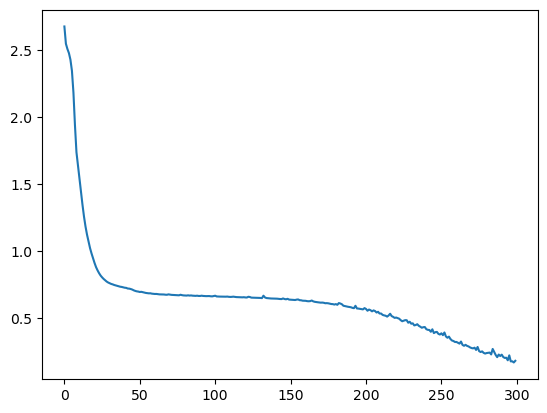

In [20]:
#plotting the losses
plt.plot(losses)


### Evaluating the model over the test data

In [21]:
y_pred = model(X_test)
print(f"MSE over the model prediction: {mean_absolute_error(y_test.tolist(), y_pred.tolist())}")

MSE over the model prediction: 0.26044596124343694


In [22]:
resort = np.argsort(ind)
test= features[resort,:]
prediction = model(torch.Tensor(test))[:,0]
test = prediction.detach().numpy().flatten()
test=torch.tensor(test)
test

tensor([-0.1740,  0.0531,  0.1688,  ..., -0.3969, -0.1525,  0.2903])

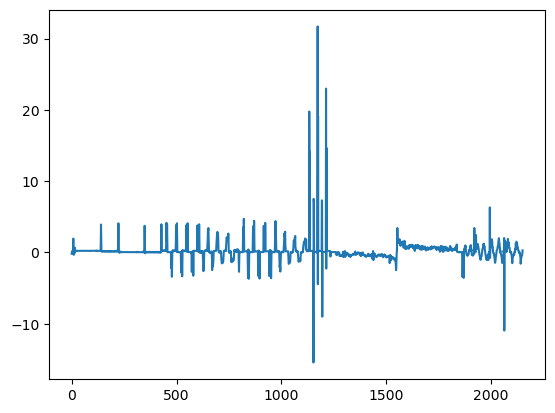

In [23]:
plt.plot(test)

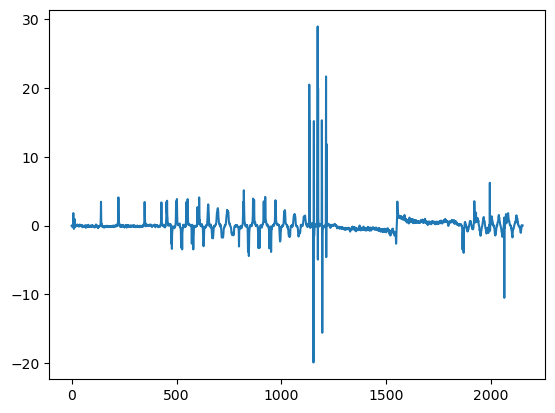

In [24]:

plt.plot(target[resort,0])

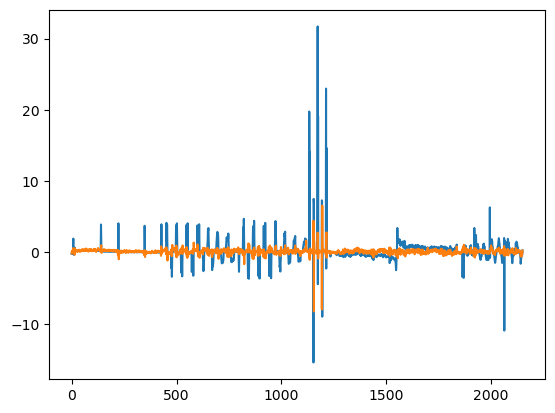

In [25]:
# plot prediction and difference between prediction and actual target
plt.plot(test)
plt.plot(test-target[resort,0])
#